In [1]:
pip install pgmpy

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sys
sys.path.append(r"C:\Users\zhossai3\Desktop\Fair_Imputation") 


import Utils
import CMI
import Inject_Missing_Values
import RR_imputer
import Sinkhorn_CMI
import SinkhornImputation
import SoftImpute



c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\__init__.py:1144: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\tensor\python_tensor.cpp:434.)
  _C._set_default_tensor_type(t)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.estimators import K2Score
from sklearn.preprocessing import KBinsDiscretizer


c:\Users\zhossai3\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data = pd.read_csv(r'C:\Users\zhossai3\Desktop\Fair_Imputation\Data\abalone\abalone.csv')


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sex            4177 non-null   int64  
 1   Length         4177 non-null   float64
 2   Diameter       4177 non-null   float64
 3   Height         4177 non-null   float64
 4   WholeWeight    4177 non-null   float64
 5   ShuckedWeight  4177 non-null   float64
 6   VisceraWeight  4177 non-null   float64
 7   ShellWeight    4177 non-null   float64
 8   Rings          4177 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 293.8 KB


Learning the structure of the Bayesian Network...


  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 2/1000000 [00:00<103:32:28,  2.68it/s]


Bayesian Network Structure:
[('Sex', 'Height'), ('Rings', 'Sex')]


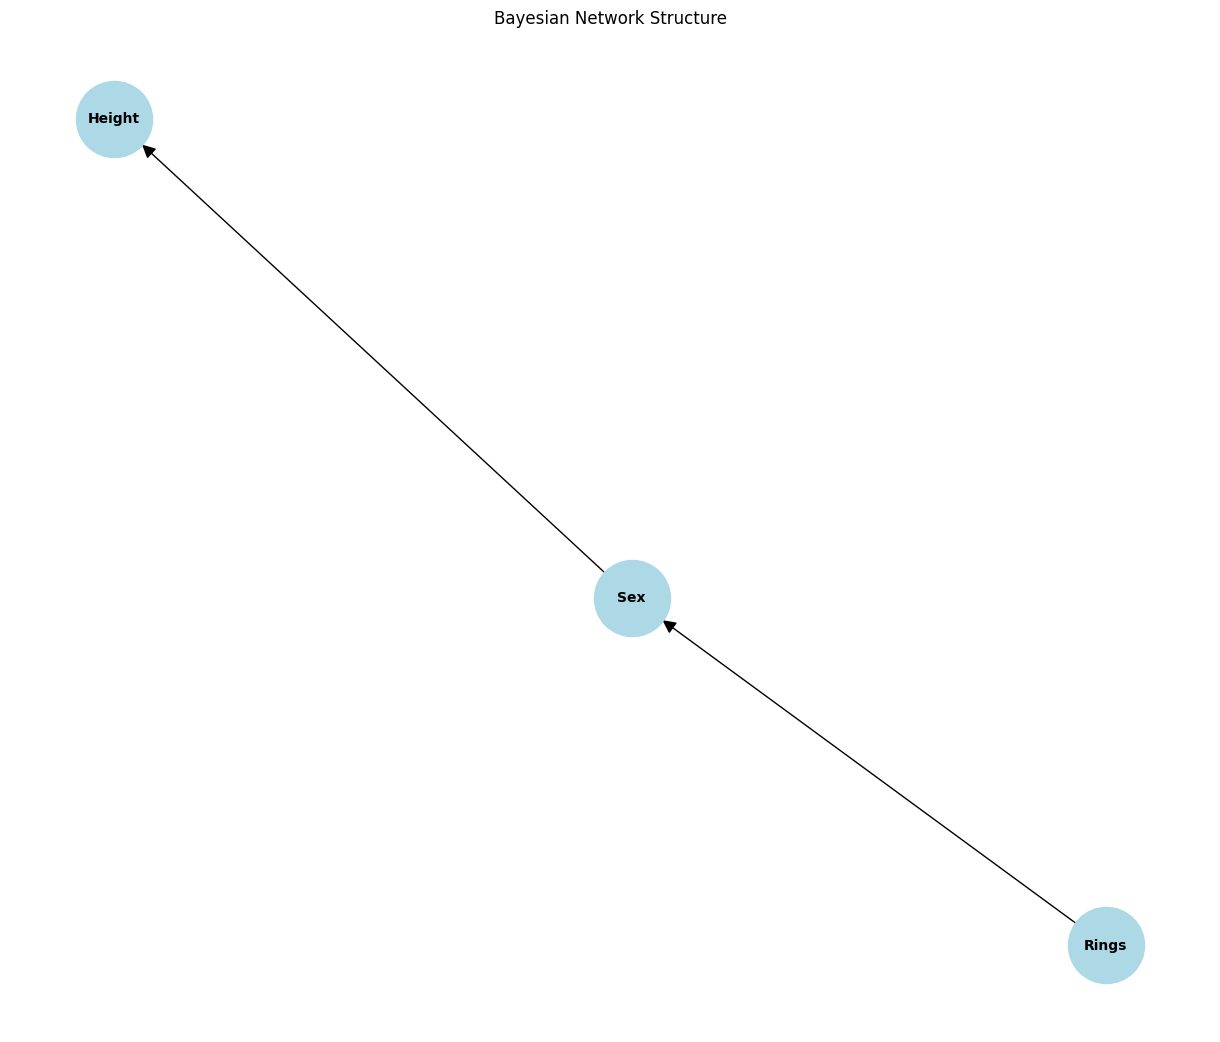

Fitting the Bayesian Network with data...


In [6]:

#only works for complete data
print("Learning the structure of the Bayesian Network...")
hc = HillClimbSearch(data)
model = hc.estimate(scoring_method=BicScore(data))

# Create the Bayesian Network from the learned structure
bayesian_net = BayesianNetwork(model.edges())

# Step 4: Visualize the Bayesian Network
def visualize_bayesian_network(bayesian_net):
    # Create a networkx graph from the Bayesian Network
    G = nx.DiGraph()
    G.add_edges_from(bayesian_net.edges())

    # Plot the graph
    plt.figure(figsize=(12, 10))
    pos = nx.spring_layout(G)  # Define layout
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_size=3000,
        node_color="lightblue",
        font_size=10,
        font_weight="bold",
        arrowsize=20,
    )
    plt.title("Bayesian Network Structure")
    plt.show()

print("Bayesian Network Structure:")
print(bayesian_net.edges())
visualize_bayesian_network(bayesian_net)

# Step 5: Fit the Bayesian Network with the data
print("Fitting the Bayesian Network with data...")
bayesian_net.fit(data, estimator=MaximumLikelihoodEstimator)


In [7]:
inference = VariableElimination(bayesian_net)

# Example Query 2: Joint probability of two variables
query_result = inference.query(variables=["Sex","Height"])
print("\nJoint Probability")
print(query_result)



Joint Probability
+--------+---------------+-------------------+
| Sex    | Height        |   phi(Sex,Height) |
+========+===============+===================+
| Sex(1) | Height(0.0)   |            0.0000 |
+--------+---------------+-------------------+
| Sex(1) | Height(0.01)  |            0.0000 |
+--------+---------------+-------------------+
| Sex(1) | Height(0.015) |            0.0000 |
+--------+---------------+-------------------+
| Sex(1) | Height(0.02)  |            0.0000 |
+--------+---------------+-------------------+
| Sex(1) | Height(0.025) |            0.0002 |
+--------+---------------+-------------------+
| Sex(1) | Height(0.03)  |            0.0000 |
+--------+---------------+-------------------+
| Sex(1) | Height(0.035) |            0.0000 |
+--------+---------------+-------------------+
| Sex(1) | Height(0.04)  |            0.0010 |
+--------+---------------+-------------------+
| Sex(1) | Height(0.045) |            0.0002 |
+--------+---------------+---------------

In [18]:
result = inference.query(variables=["Height"], evidence={"Sex": True})
print("Conditional Probability P(Housing | Risk = True):")
print(result)

Conditional Probability P(Housing | Risk = True):
+---------------+---------------+
| Height        |   phi(Height) |
+===============+===============+
| Height(0.0)   |        0.0000 |
+---------------+---------------+
| Height(0.01)  |        0.0000 |
+---------------+---------------+
| Height(0.015) |        0.0000 |
+---------------+---------------+
| Height(0.02)  |        0.0000 |
+---------------+---------------+
| Height(0.025) |        0.0007 |
+---------------+---------------+
| Height(0.03)  |        0.0000 |
+---------------+---------------+
| Height(0.035) |        0.0000 |
+---------------+---------------+
| Height(0.04)  |        0.0026 |
+---------------+---------------+
| Height(0.045) |        0.0007 |
+---------------+---------------+
| Height(0.05)  |        0.0020 |
+---------------+---------------+
| Height(0.055) |        0.0013 |
+---------------+---------------+
| Height(0.06)  |        0.0013 |
+---------------+---------------+
| Height(0.065) |        0.0046 

In [9]:
# Print nodes and edges
print("Nodes in the Bayesian Network:")
print(bayesian_net.nodes())

print("Edges in the Bayesian Network:")
print(bayesian_net.edges())


Nodes in the Bayesian Network:
['Sex', 'Height', 'Rings']
Edges in the Bayesian Network:
[('Sex', 'Height'), ('Rings', 'Sex')]
